# Étudiants :
- ### Mehdi LAKBAR
- ### Léo PORTE

# Tâches effectuées
- TME : predicting dynamics with Neural-ODE
- Bonus 1 : experimentations avec remplacement des residual networks par des ODEs pour du supervisé
- Bonus 2 : implémentation et test de 4D-Var pour la prédiction de mouvements du pendule
- Bonus 3 : expérimentation d'APHYNITY (Yin et al, 2021)


# TP 14: Predicting dynamics with Neural-ODE

**The goal of this pratical is use machine learning models to predict the
evolution of dynamical systems driven by physical laws, *e.g.* ordinary
Differential Equations (ODE).**

Let us considers a physcial system in Newtonian mechanichs composed of a
**damped pendulum**, with length $l$ and mass $m$, and $\theta$ being the
angle with respect to the vertical direction:

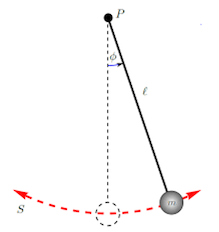

**Let us denote $\dot{\theta_t}:=\frac{d\theta}{dt}$ and
$\ddot{\theta}_t:=\frac{d^2\theta}{dt^2}$ as the first and second temporal
derivatives of $\theta$.** The dynamics of the pendulum is driven bt the
following ODE on $\theta$:


\begin{equation} \ddot{\theta_t} + \omega_0^2~ sin\left(\theta_t\right) +
\alpha \dot{\theta}_t = 0 \end{equation}

where $\omega_0 = \sqrt{\frac{g}{l}}$ ($g$ is the gravitational constant), and
$\alpha = \frac{k}{ml^2}$ is the friction coefficient.

In the general case, the ODE in Eq (\ref{eq1}) does not have a closed-form
solution. Let us denote as $\mathbf{Y}_t=(\theta_t, \dot{\theta}_t)$ the 2d
state vector of the pendulum.



**<u>Question 1:</u> show that
 $\dot{\mathbf{Y}_t}=f\left({\mathbf{Y}_t}\right)$, *i.e* that the evolution
 of $\mathbf{Y}$ follows a first-order ODE. Give the expression of f.**

# **ANSWER**

To show that the evolution of $\mathbf{Y}_t = (\theta_t, \dot{\theta}_t)$ follows a first-order ODE, we need to express $\dot{\mathbf{Y}_t}$ as a function $f(\mathbf{Y}_t)$.

Given that $\mathbf{Y}_t = (\theta_t, \dot{\theta}_t)$, its derivative with respect to time $t$ is:

$$
\dot{\mathbf{Y}_t} = \left( \frac{d\theta_t}{dt}, \frac{d\dot{\theta}_t}{dt} \right)
$$

This derivative represents the change in both the angle $\theta_t$ and its first derivative $\dot{\theta}_t$ over time. According to the given ODE, we have:

$$
\ddot{\theta}_t + \omega_0^2 \sin(\theta_t) + \alpha \dot{\theta}_t = 0
$$

To find $\dot{\mathbf{Y}_t}$ as a function of $\mathbf{Y}_t$, we can rearrange the above equation to solve for $\ddot{\theta}_t$ (the second derivative of $\theta_t$):

$$
\ddot{\theta}_t = -\omega_0^2 \sin(\theta_t) - \alpha \dot{\theta}_t
$$

Now, we can express $\dot{\mathbf{Y}_t}$ in terms of $\mathbf{Y}_t$:

$$
\dot{\mathbf{Y}_t} = \left( \dot{\theta}_t, -\omega_0^2 \sin(\theta_t) - \alpha \dot{\theta}_t \right)
$$

The function $f(\mathbf{Y}_t)$ that represents this system is:

$$
f(\mathbf{Y}_t) = \left( \dot{\theta}_t, -\omega_0^2 \sin(\theta_t) - \alpha \dot{\theta}_t \right)
$$

This function shows that the evolution of the state vector $\mathbf{Y}_t$ of the damped pendulum is governed by a first-order ODE, where each component of $\mathbf{Y}_t$ is expressed as a function of the components of $\mathbf{Y}_t$ itself.

# **END OF ANSWER**


From a given initial condition $\mathbf{Y}_0=(\theta_0, \dot{\theta}_0)$, we
can estimate the state vector $\mathbf{Y}_t$ at any time $t$:

\begin{equation} \mathbf{Y}_t = \mathbf{Y}_0 + \int_0^t \dot{\mathbf{Y}_t} ~dt
= \mathbf{Y}_0 + \int_0^t f\left(\mathbf{Y}_t\right) dt
\end{equation}

where $f\left( \mathbf{Y}_t \right)$ only depends on the current state
$\mathbf{Y}_t$ at time $t$. The integral in Eq (\ref{eq2}) can be approximated
with numerical schemes. The Euler method is simplest one (see figure below):
starting from $\mathbf{Y}_0$, we have $\mathbf{Y}_{t+1} = \mathbf{Y}_{t} +
f\left(\mathbf{Y}_t\right)$ $\forall t>1$. The has been extensive studies for
developing improved numerical solvers in the last centuries, e.g. different
orders of Runge-Kutta solvers.

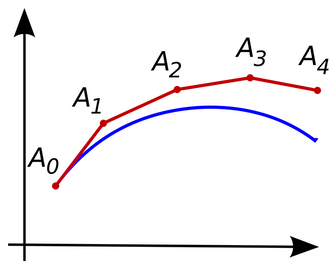


## Part I. Generating damped pendulum simulations
First, lets do some import

In [3]:
!pip install torchdiffeq

In [4]:
import math, shelve
import os

from collections import OrderedDict

import torch
import numpy as np
from scipy.integrate import solve_ivp

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim

from torchdiffeq import odeint_adjoint, odeint

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [20, 10]

if torch.cuda.is_available():
  device = "cuda:0"
else:
  device = "cpu"

### I.a) DampledPendulum

**We will write a DampledPendulum Dataset, which simulates different pendulum trajectories from differents initial conditions. Fill the code in the code in the following DampledPendulum class. We use the following setting:** $\omega_0^2= \frac{\Pi}{6}$, $\alpha= 0.2$, time hoziron : 10, with $dt=0.5$

You have to fill the `__init__`, `__len__` and  `__getitem__` functions. For `__getitem__`, the goal is to simulate a given trajectory from an initial condition:
- The function `_get_initial_condition` is provided
- To perform the simulation in `__getitem__`, you need to:
    - Call the `_get_initial_condition`
    - Call the solver: we will use the solve_ivp method from from `scipy.integrate`, using the 'DOP853' method (Explicit Runge-Kutta method of order 8).
- Since the simulation is computationally demanding, it can be a good idea to store the states in the class

In [29]:
class DampledPendulum(Dataset):
    def __init__(self, num_seq, time_horizon, dt):  # , params=None), group='train'):
        super().__init__()

        self.omega0_square= np.pi / 6
        self.alpha = 0.2
        self.len = num_seq
        self.time_horizon = time_horizon
        self.dt = dt
        self.data = [None] * num_seq

    def _get_initial_condition(self):
        """Returns the vector of initial conditions"""
        y0 = np.random.randn(2) * 2.0 - 1
        r = np.random.rand() + 1.3
        y0 = y0 / np.sqrt((y0**2).sum()) * r

        return y0

    def _get_state_derivative(self, t, x):
        q, p = np.split(x, 2)

        dxdt = [p, -self.omega0_square * np.sin(q) - self.alpha * p]
        return np.concatenate(dxdt, axis=-1)

    def __getitem__(self, index: int):
        t_eval = torch.arange(0, self.time_horizon, self.dt)

        if self.data[index] is None:
            y0 = self._get_initial_condition()
            states = solve_ivp(fun=self._get_state_derivative, t_span=(0, self.time_horizon), y0=y0, method='DOP853', t_eval=t_eval, rtol=1e-10).y
            self.data[index] = states
        else:
            states = self.data[index]
        return {'states': states, 't': t_eval.float()}

    def __len__(self):
        return self.len


### I.b) Train/test data generation

**We can now define train and test dataloader** (use 25 train/test sequences
with a batch size of 25). **Plot the resulting trajectories ($\theta$ and
optionally $\dot{\theta}$).**

In [30]:
# path = "./exp2/pendulum/pendulum"

num_seq = 25
time_horizon = 20
dt = 0.5
dataset_train = DampledPendulum(num_seq, time_horizon, dt)
dataset_test = DampledPendulum(num_seq, time_horizon, dt)


batch_size = 25
dataloader_train_params = {
    "dataset": dataset_train,
    "batch_size": batch_size,
    "num_workers": 0,
    "pin_memory": True,
    "drop_last": False,
    "shuffle": True,
}

dataloader_test_params = {
    "dataset": dataset_test,
    "batch_size": batch_size,
    "num_workers": 0,
    "pin_memory": True,
    "drop_last": False,
    "shuffle": False,
}

train_loader = DataLoader(**dataloader_train_params)
test_loader = DataLoader(**dataloader_test_params)

In [ ]:
# Show one item of the dataset

dataset_train[0]

{'states': array([[ 0.74776741, -0.18700295, -1.0112579 , -1.65672379, -2.11968328,
         -2.43304589, -2.63530649, -2.75746843, -2.82088395, -2.83859356,
         -2.81706167, -2.75745204, -2.65638427, -2.50635272, -2.29623759,
         -2.01272104, -1.6440699 , -1.18794673, -0.6625042 , -0.11279713,
          0.39795163,  0.81321036,  1.1000486 ,  1.24956504,  1.26714525,
          1.16460571,  0.95812733,  0.67055453,  0.3342322 , -0.01013297,
         -0.32048503, -0.56271008, -0.71625598, -0.77415311, -0.74013851,
         -0.6260724 , -0.45064875, -0.23834289, -0.0172849 ,  0.18486765],
        [-1.91046581, -1.79212855, -1.48103645, -1.10091579, -0.76298706,
         -0.50367491, -0.31573873, -0.17996913, -0.07797916,  0.00502741,
          0.08073753,  0.15884001,  0.24794627,  0.35592619,  0.48909037,
          0.64914525,  0.82664501,  0.99212048,  1.09438979,  1.08209676,
          0.94161696,  0.70852844,  0.43624188,  0.16389534, -0.08957566,
         -0.31528552, -0.50

<Figure size 2000x1000 with 0 Axes>

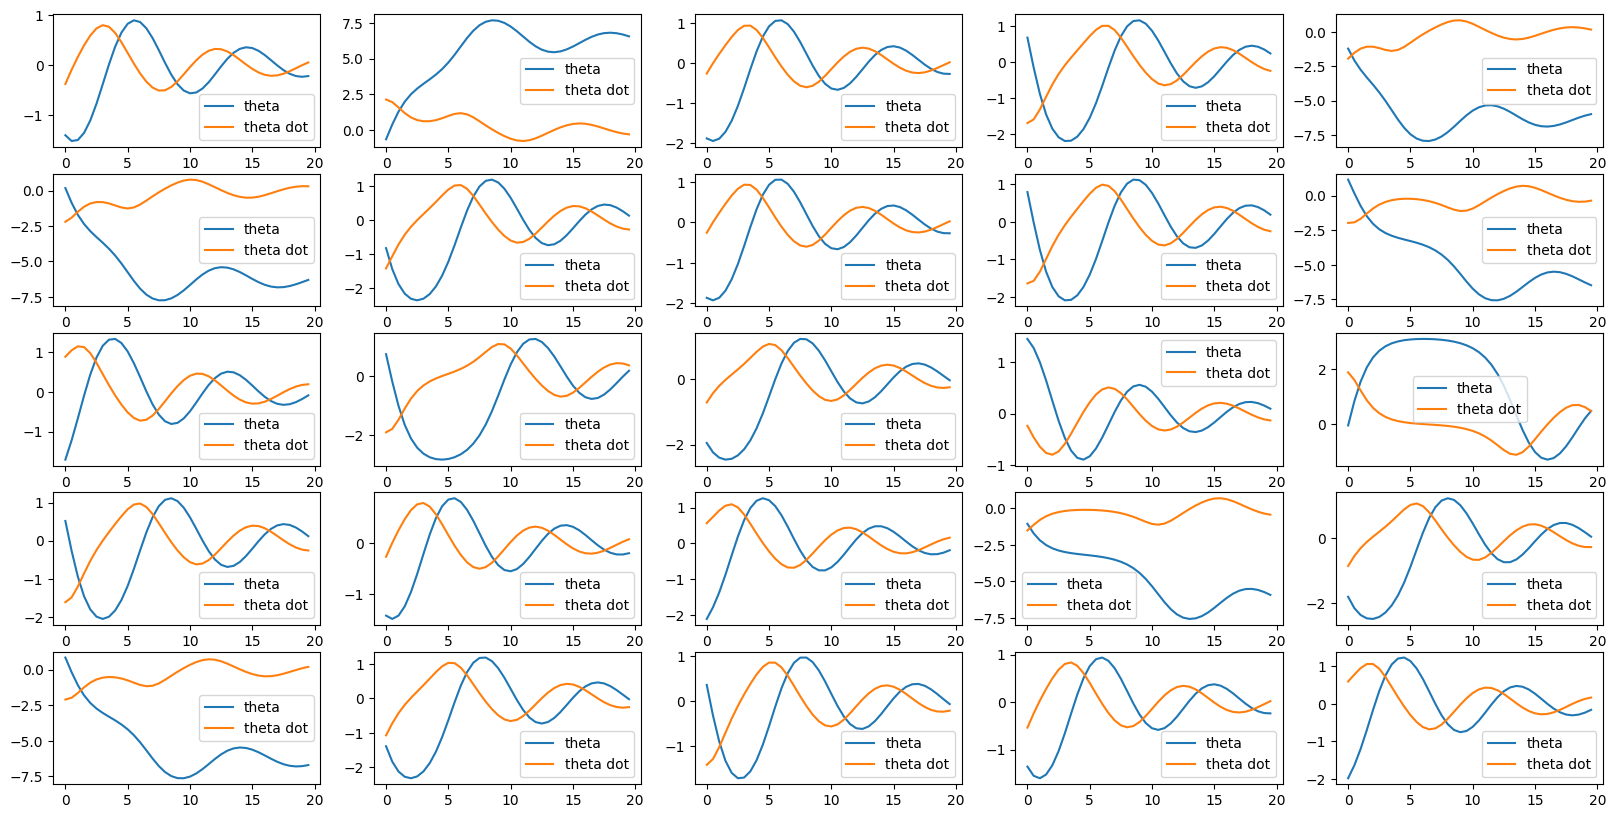

In [ ]:
data = next(iter(train_loader))
draw_dottheta = True

plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]
fig, axs = plt.subplots(5, 5)

for i in range(5):
    for j in range(5):
        index = i * 5 + j
        if index >= batch_size:
            break

        t = data["t"][index]
        theta = data["states"][index, 0, :]
        theta_dot = data["states"][index, 1, :]

        axs[i, j].plot(t, theta, label='theta')
        if draw_dottheta:
            axs[i, j].plot(t, theta_dot, label='theta dot')

        axs[i, j].legend()

<Figure size 2000x1000 with 0 Axes>

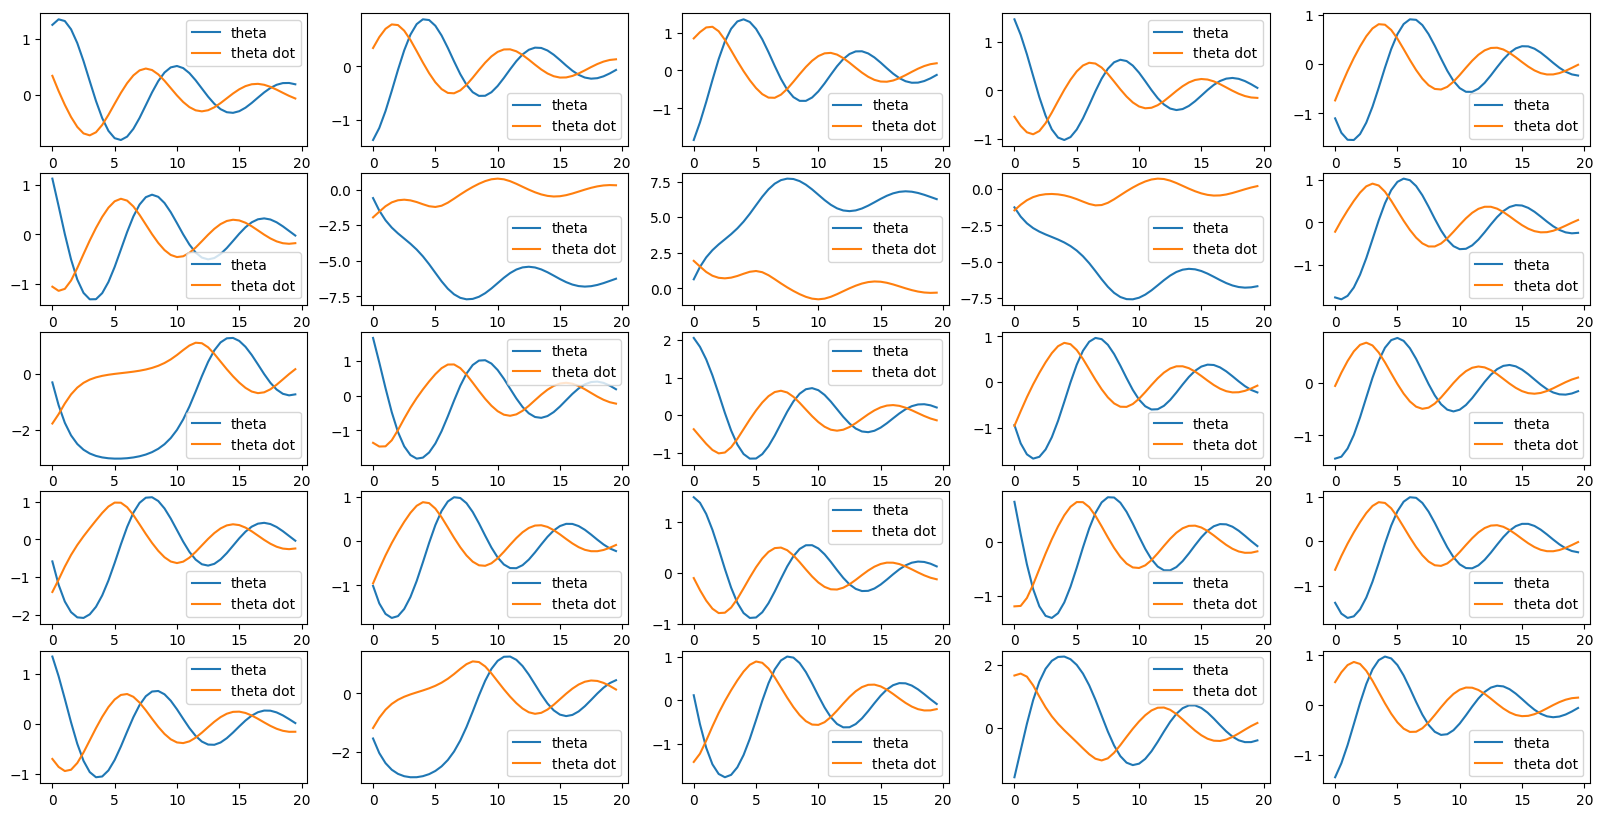

In [ ]:
data_test = next(iter(test_loader))

plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]
fig, axs = plt.subplots(5, 5)
draw_dottheta = True

for i in range(5):
    for j in range(5):
        index = i * 5 + j
        if index >= batch_size:  # Ensure we do not exceed batch size
            break

        t = data_test["t"][index]
        theta = data_test["states"][index, 0, :]
        theta_dot = data_test["states"][index, 1, :]

        axs[i, j].plot(t, theta, label='theta')
        if draw_dottheta:
            axs[i, j].plot(t, theta_dot, label='theta dot')

        axs[i, j].legend()


### Plot initial condition distribution

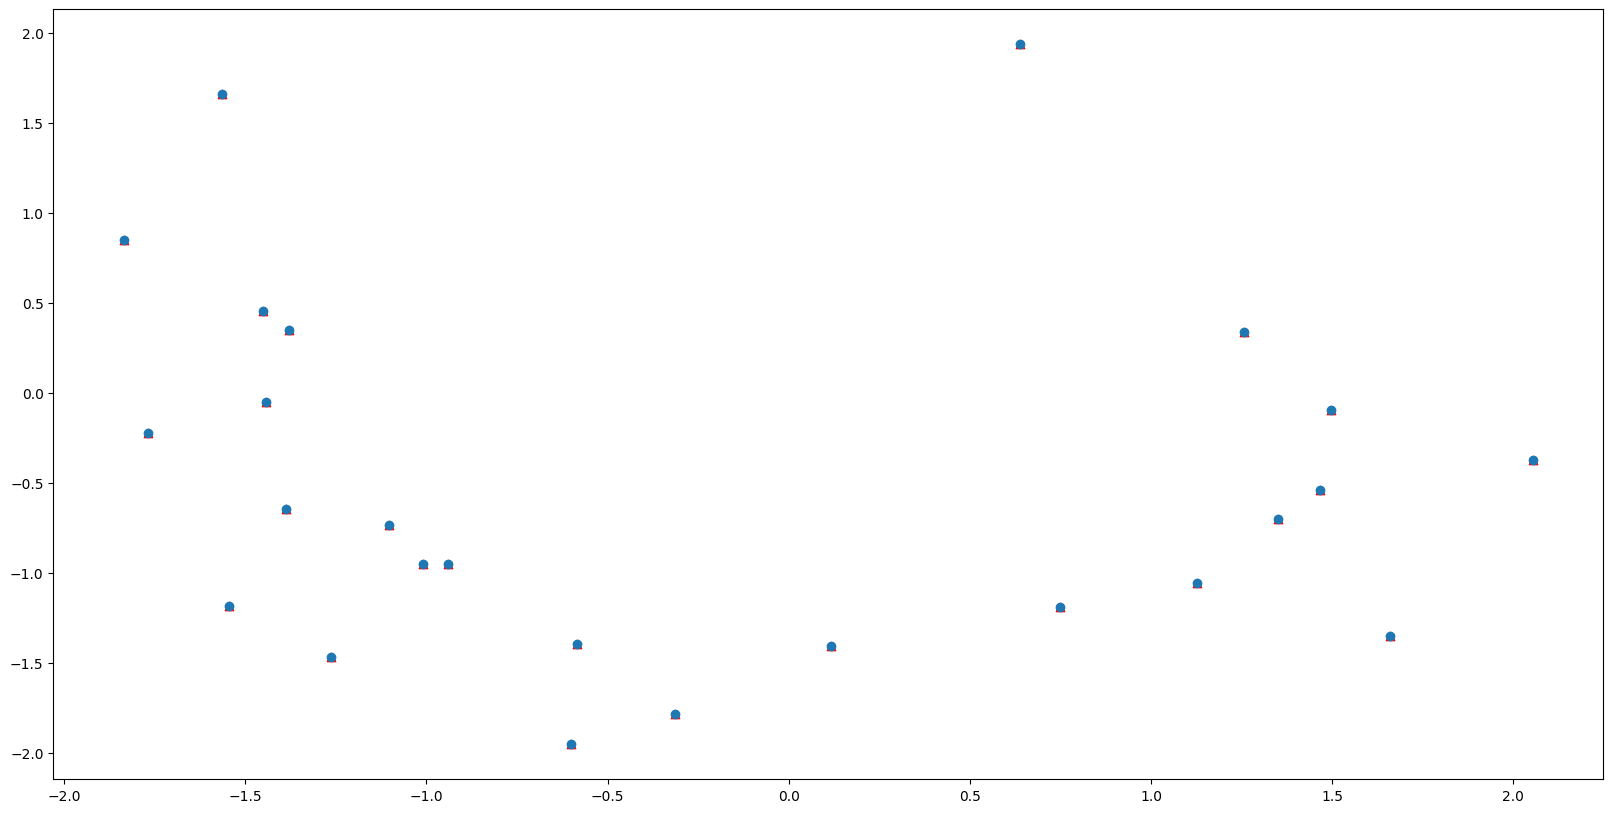

In [ ]:
data = data_test
theta0_train = data["states"][:, 0, 0]
dtheta0_train = data["states"][:, 1, 0]

theta0_test = data_test["states"][:, 0, 0]
dtheta0_test = data_test["states"][:, 1, 0]

plt.figure()
plt.scatter(theta0_train, dtheta0_train, marker="^", c="r")
plt.scatter(theta0_test, dtheta0_test)


## 2) Predicting trajectories with Neural-ODE

The goal is to use the Neural-ODE method [1] to predict the future trajectory
from an initial condition. **More precisely, the idea is to define a
parametric model, *e.g.* an neural network, to predict the state's derivative
from the current state value:
$\dot{\mathbf{Y}_t}=f_{\theta}\left({\mathbf{Y}_t}\right)$, with $\theta$
being the neural net parameters. From an initial condition $\mathbf{Y}_0$ and
$f_{\theta}\left({\mathbf{Y}_t}\right)$, we can then use Eq (\ref{eq2}) to
predict the full predicted trajectory $\hat{\mathbf{Y}}$. The goal is to
optimize $\theta$ parameters such that predicted trajectories are close to the
GT trajectories in the training set.**

\begin{equation} \hat{\mathbf{Y}_t}  = \mathbf{Y}_0 + \int_0^t
f_{\theta}\left(\mathbf{Y}_t\right) dt \end{equation}


**Let's fill the DerivativeEstimator class to predict the the state's
derivative.** We will use a simple MLP (2 hidden layers + ReLU) for prediction
since the state is a 2D vector.


In [ ]:
class DerivativeEstimator(nn.Module):
    def __init__(self, n_state: int, n_hidden: int):
        super().__init__()
        # Define the layers of the MLP
        self.fc1 = nn.Linear(n_state, n_hidden)  # First hidden layer
        self.fc2 = nn.Linear(n_hidden, n_hidden)  # Second hidden layer
        self.fc3 = nn.Linear(n_hidden, n_state)   # Output layer

        self.relu = nn.ReLU()  # ReLU activation function

    def forward(self, t, state):
        # Forward pass through the MLP
        x = self.relu(self.fc1(state))  # First hidden layer with ReLU
        x = self.relu(self.fc2(x))      # Second hidden layer with ReLU
        x = self.fc3(x)                 # Output layer, no activation function here
        return x


**The forecaster will perform the prediction from a initial state $y_0$**. To
perform the numerical integration, we use the [`odeint` method from
torchdiffeq](https://github.com/rtqichen/torchdiffeq). We will use the generic
'rk4' solver to perform numerical integration. **Fill the following Forecaster
class with:**
- A constructor creating a reference to an DerivativeEstimator instance
- the forward method calls the `odeint` method to perform integration from an
  initial $y_0$ state. **N.B.**: the output dimensions after calling `odeint`
  will be `T x batch_size x n_c`, swap them to fit the requested Pytorch
  standard (`batch_size x n_c X T`)

In [ ]:
class Forecaster(nn.Module):
    def __init__(self, n_state, n_hidden, method="rk4"):
        super().__init__()

        self.derivative_estimator = DerivativeEstimator(n_state, n_hidden)
        self.method = method

    def forward(self, y0: torch.Tensor, t: int):
        """Computes the $y_t$ prediction at time $t$
        given the initial state of size (B x N_c x T)
        """

        # Perform numerical integration
        y_t = odeint(self.derivative_estimator, y0, t, method=self.method)

        # y_t will be of shape [T, batch_size, n_c], so we need to swap the dimensions
        y_t = y_t.permute(1, 2, 0).to(device)  # Swaps to [batch_size, n_c, T]

        return y_t


### Write the training loop!

For each batch:
- Get the first state of each training trajectory
- Perform prediction of the forecaster for each time step of the horizon
- We will use a simple MSE loss between the ground truth and predicted
  trajectories.
- Use an Adam optimizer (default paramters)
- Plot the train / test trajectories

In [ ]:
n_state = 2
n_hidden = 200
n_epochs = 1001
tau_1 = 1e-3

forecaster_net = Forecaster(n_state, n_hidden).to(device)
optimizer = optim.Adam(forecaster_net.parameters(), lr=tau_1, betas=(0.9, 0.999))
traj_loss = nn.MSELoss()

losses = []
for e in range(n_epochs):
    # Training loop
    loss_tmp = []
    for batch in train_loader:
        batch["states"] = batch["states"].float().to(device)
        batch["t"] = batch["t"].float().to(device)

        optimizer.zero_grad()  # Clear gradients

        y0 = batch["states"][:, :, 0]  # Initial state

        t = batch["t"][0]  # Initial time

        pred = forecaster_net(y0, t)  # Predict the trajectory

        loss = traj_loss(pred[:, 0, :], batch["states"][:, 0, :])  # Compute MSE loss
        loss_tmp.append(loss.item())
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

    losses.append(np.array(loss_tmp).mean())

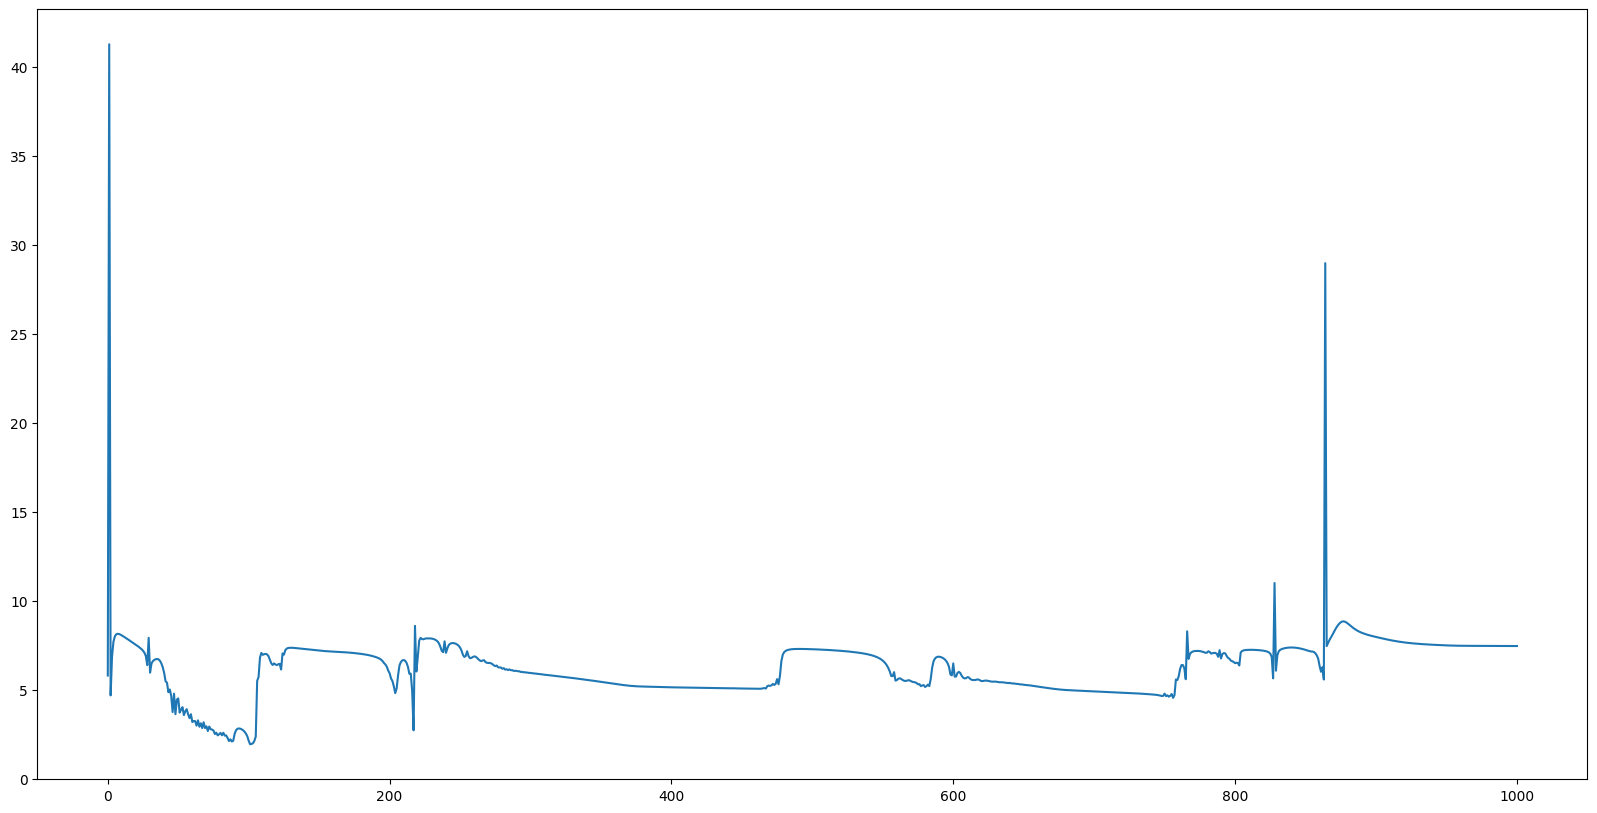

In [ ]:
plt.plot(losses)

<Figure size 2000x1000 with 0 Axes>

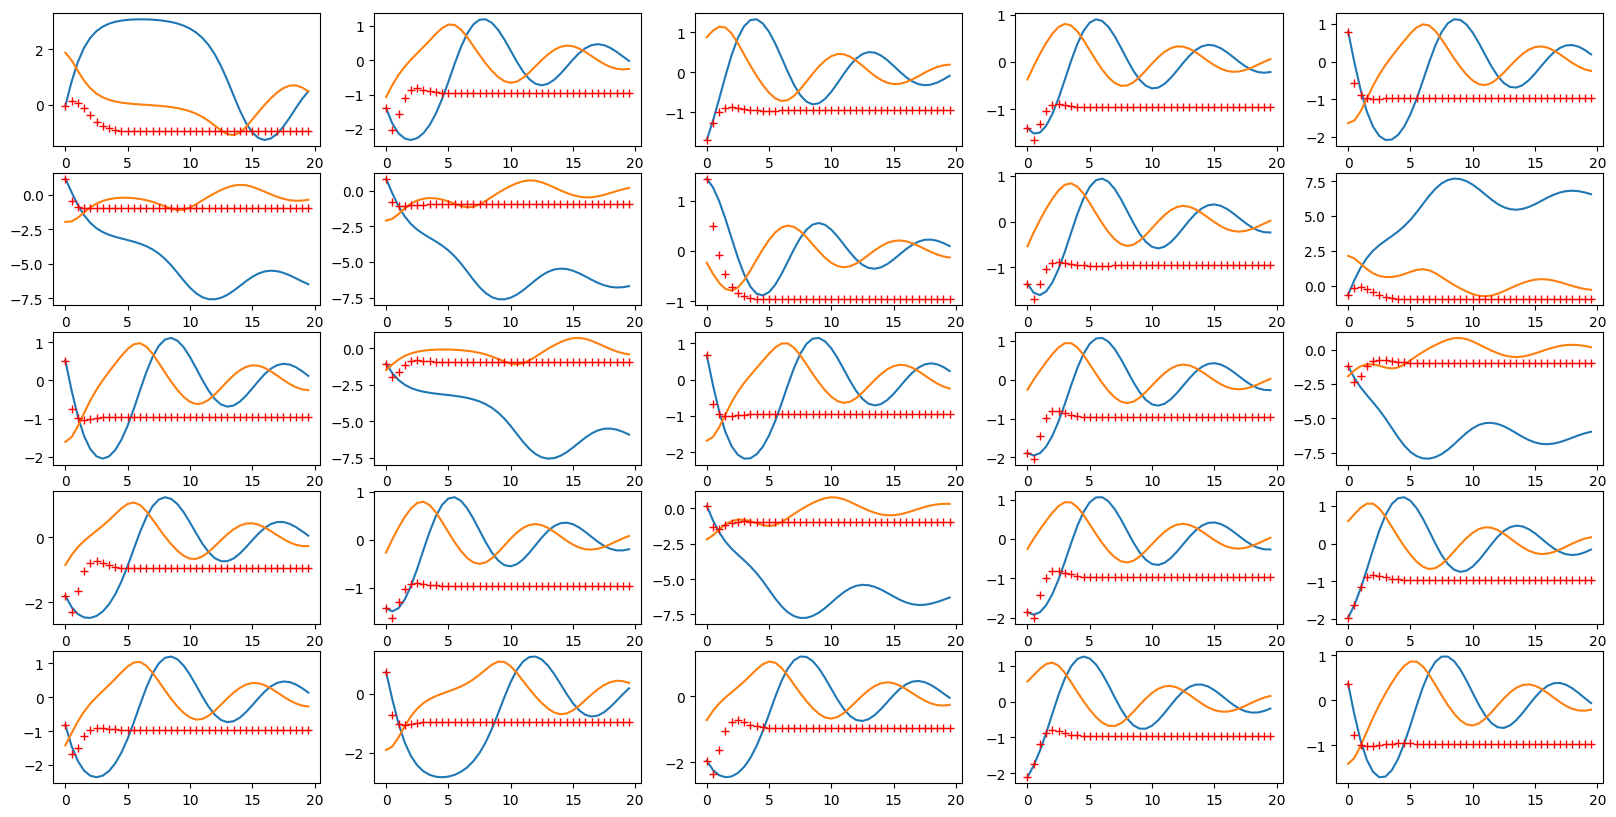

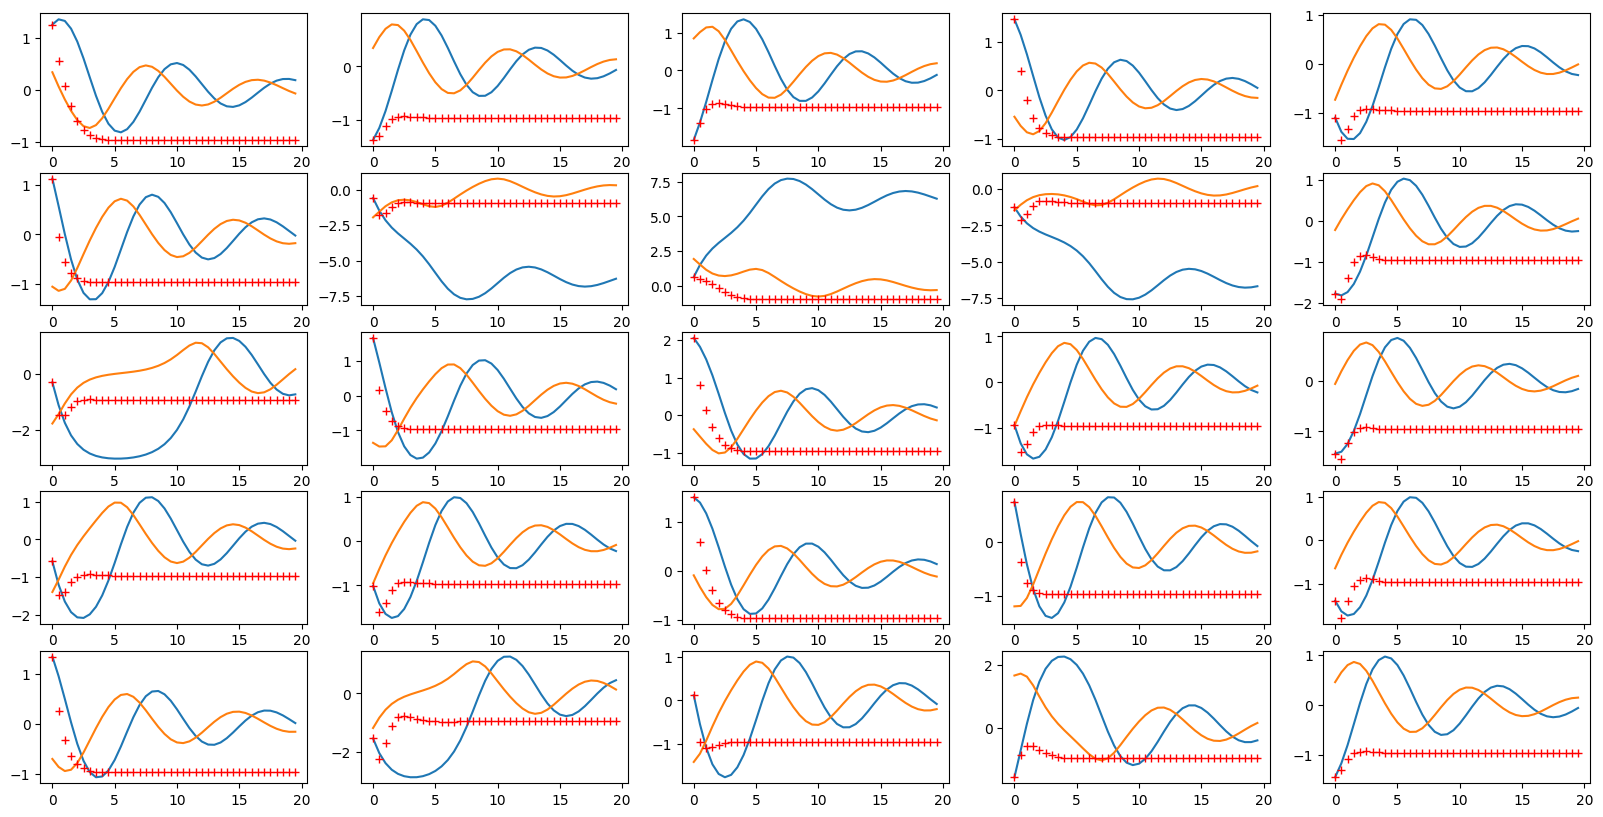

In [ ]:
# The code below plots the predicted values

# Blue line = theta, orange = theta dot, red = predictions

plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]

with torch.no_grad():
    for batch in train_loader:
        y0 = batch["states"][:, :, 0].float().to(device)
        t = batch["t"][0].float().to(device)
        p = forecaster_net(y0, t).cpu().detach().numpy()
        fig, axs = plt.subplots(5, 5)

        for i in range(5):
            for j in range(5):
                index = i * 5 + j
                if index >= batch_size:
                    break  # Avoid index out of range if dataset size is not a multiple of 25

                axs[i, j].plot(
                    batch["t"][index],
                    batch["states"][index, 0, :],
                    batch["t"][index],
                    batch["states"][index, 1, :],
                    batch["t"][index],
                    p[index, 0, :],
                    "r+",
                )

    for batch_test in test_loader:
        y0 = batch_test["states"][:, :, 0].float().to(device)
        t = batch_test["t"][0].float().to(device)
        ptest = forecaster_net(y0, t).cpu().detach().numpy()

        fig, axs = plt.subplots(5, 5)
        for i in range(5):
            for j in range(5):
                index = i * 5 + j
                if index >= batch_size:
                    break  # Avoid index out of range if dataset size is not a multiple of 25

                axs[i, j].plot(
                    batch_test["t"][index],
                    batch_test["states"][index, 0, :],
                    batch_test["t"][index],
                    batch_test["states"][index, 1, :],
                    batch_test["t"][index],
                    ptest[index, 0, :],
                    "r+",
                )

En comparant nos résultats avec ceux du cours, à savoir :

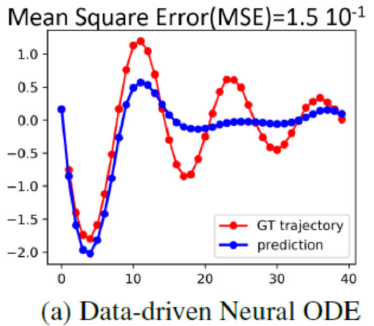

Et en considérant notre MSE (nous ne montrons que celle du train puisque les prédictions obtenues en train et en test sont globalement de la même forme) :

In [ ]:
print("MSE de notre modèle en train:", losses[-1])

MSE de notre modèle en train: 7.478639125823975


Nous pouvons en conclure que bien que nos prédictions ont un certain sens si l'on s'en tient aux résultats du cours (des variations sur la courbe amoindries avec le temps), force est de constater que nos résultats sont en deçà de ce qui pourrait être attendu. Notre MSE fait un bond de x20 par rapport à celle du cours, puisque nos trajectoires prédites sont trop "lisses".

Les raisons de cet écart pourraient être attribuées au modèle utilisé pour le DerivativeEstimator, qui serait trop simple (MLP de 2 layers avec une activation ReLU) par rapport à celui utilisé dans le papier que le cours cite. Une autre hypothèse serait que notre training loop soit sujette aux problèmes de minima locaux, mais nous choisissons de maintenir ces résultats puisque les hyper-paramètres utilisés étaient prédéfinis.


# Bonus
Experiment Neural ODE for **replacing residual networks with ODEs for
supervised learning**: see section 3 in [this
paper](https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf).

Model implementation is inspired from https://github.com/rtqichen/torchdiffeq/ repository

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import time

In [ ]:
# Settings
network = 'odenet'  # 'resnet' or 'odenet'
tol = 1e-3
adjoint = False
downsampling_method = 'conv'  # 'conv' or 'res'
nepochs = 20
data_aug = True
lr = 0.1
batch_size = 128
test_batch_size = 1000
save_dir = './experiment1'
debug = False
gpu = 0

# Ensure save directory exists
os.makedirs(save_dir, exist_ok=True)

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)


class ResBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.norm1 = norm(inplanes)
        self.downsample = downsample
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.norm2 = norm(planes)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        shortcut = x if self.downsample is None else self.downsample(x)
        x = F.relu(self.norm1(x), inplace=True)
        x = self.conv1(x)
        x = F.relu(self.norm2(x), inplace=True)
        x = self.conv2(x)
        return x + shortcut


class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)


class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=tol, atol=tol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value


class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)


def get_mnist_loaders(data_aug=False, batch_size=128, test_batch_size=1000, perc=1.0):
    if data_aug:
        transform_train = transforms.Compose([
            transforms.RandomCrop(28, padding=4),
            transforms.ToTensor(),
        ])
    else:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform_train), batch_size=batch_size,
        shuffle=True, num_workers=2, drop_last=True
    )

    train_eval_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    test_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=False, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    return train_loader, test_loader, train_eval_loader


def one_hot(x, K):
    return np.array(x[:, None] == np.arange(K)[None, :], dtype=int)


def accuracy(model, dataset_loader):
    total_correct = 0
    for x, y in dataset_loader:
        x = x.to(device)
        y = one_hot(np.array(y.numpy()), 10)

        target_class = np.argmax(y, axis=1)
        predicted_class = np.argmax(model(x).cpu().detach().numpy(), axis=1)
        total_correct += np.sum(predicted_class == target_class)
    return total_correct / len(dataset_loader.dataset)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [ ]:
# Model, optimizer, and dataloaders
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
train_loader, test_loader, train_eval_loader = get_mnist_loaders(data_aug, batch_size, test_batch_size)

is_odenet = network == 'odenet'

downsampling_layers = nn.Sequential(
    nn.Conv2d(1, 64, 3, 1),
    norm(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, 4, 2, 1),
    norm(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, 4, 2, 1)
) if downsampling_method == 'conv' else nn.Sequential(
    nn.Conv2d(1, 64, 3, 1),
    ResBlock(64, 64, stride=2, downsample=conv3x3(64, 64, 2)),
    ResBlock(64, 64, stride=2, downsample=conv3x3(64, 64, 2))
)

feature_layers = ODEBlock(ODEfunc(64)) if is_odenet else nn.Sequential(*[ResBlock(64, 64) for _ in range(6)])

fc_layers = nn.Sequential(
    norm(64),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1)),
    Flatten(),
    nn.Linear(64, 10)
)

model = nn.Sequential(
    downsampling_layers,
    feature_layers,
    fc_layers
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
print("Number of parameters of ODENet:", count_parameters(model))

Number of parameters of ODENet: 208266


Le nombre de paramètres de notre ODENet est légèrement inférieur à celui du papier (220k)

In [ ]:
def validate(model, criterion, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Initialize lists for data collection
nfe_forward_epoch = []
nfe_backward_epoch = []
time_epoch = []
train_losses = []
val_accuracies = []
numerical_error_epoch = []

# Training loop
best_acc = 0
for epoch in range(nepochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    nfe_forward_total = 0
    nfe_backward_total = 0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        # Reset NFE counter of the ODEBlock, ODEBlock is the first feature layer after downsampling layers
        ode_block_index = 1
        model[ode_block_index].odefunc.nfe = 0

        logits = model(x)

        # Get NFE after forward pass
        nfe_forward = model[ode_block_index].odefunc.nfe
        nfe_forward_total += nfe_forward

        loss = criterion(logits, y)
        loss.backward()

        # Get NFE after backward pass
        nfe_backward = model[ode_block_index].odefunc.nfe - nfe_forward
        nfe_backward_total += nfe_backward

        optimizer.step()
        running_loss += loss.item()

    # Record statistics for the epoch
    nfe_forward_epoch.append(nfe_forward_total / len(train_loader))
    nfe_backward_epoch.append(nfe_backward_total / len(train_loader))
    time_epoch.append(time.time() - start_time)
    train_losses.append(running_loss / len(train_loader))

    # Validation
    with torch.no_grad():
      val_acc = accuracy(model, test_loader)
      val_accuracies.append(val_acc)
      val_loss = validate(model, criterion, test_loader)
      numerical_error_epoch.append(val_loss)

    # Save model if it has better accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))

    print(f'Epoch {epoch+1}/{nepochs}, Loss: {running_loss / len(train_loader):.4f}, '
          f'Validation Accuracy: {val_acc:.4f}, Time: {time_epoch[-1]:.2f}s, '
          f'NFE Forward: {nfe_forward_epoch[-1]}, NFE Backward: {nfe_backward_epoch[-1]}')

Epoch 1/20, Loss: 0.5891, Validation Accuracy: 0.9809, Time: 41.85s, NFE Forward: 20.08974358974359, NFE Backward: 0.0
Epoch 2/20, Loss: 0.0641, Validation Accuracy: 0.9915, Time: 41.52s, NFE Forward: 20.0, NFE Backward: 0.0
Epoch 3/20, Loss: 0.0456, Validation Accuracy: 0.9910, Time: 42.41s, NFE Forward: 20.0, NFE Backward: 0.0
Epoch 4/20, Loss: 0.0379, Validation Accuracy: 0.9895, Time: 42.19s, NFE Forward: 20.0, NFE Backward: 0.0
Epoch 5/20, Loss: 0.0330, Validation Accuracy: 0.9917, Time: 41.94s, NFE Forward: 20.0, NFE Backward: 0.0
Epoch 6/20, Loss: 0.0291, Validation Accuracy: 0.9932, Time: 41.74s, NFE Forward: 20.128205128205128, NFE Backward: 0.0
Epoch 7/20, Loss: 0.0256, Validation Accuracy: 0.9948, Time: 42.21s, NFE Forward: 20.166666666666668, NFE Backward: 0.0
Epoch 8/20, Loss: 0.0221, Validation Accuracy: 0.9940, Time: 43.32s, NFE Forward: 20.346153846153847, NFE Backward: 0.0
Epoch 9/20, Loss: 0.0213, Validation Accuracy: 0.9936, Time: 43.61s, NFE Forward: 20.564102564102

In [ ]:
print("Test error:", (1 - val_acc)*100, "%")

Test error: 0.5499999999999949 %


Dans le papier, cette test error est de 0.42%, notre résultat est donc cohérent puisque le modèle a été entraîné sur 160 epochs au lieu de 20 pour nous, et que l'accuracy du modèle augmente en moyenne en fonction ce nombre d'epochs.

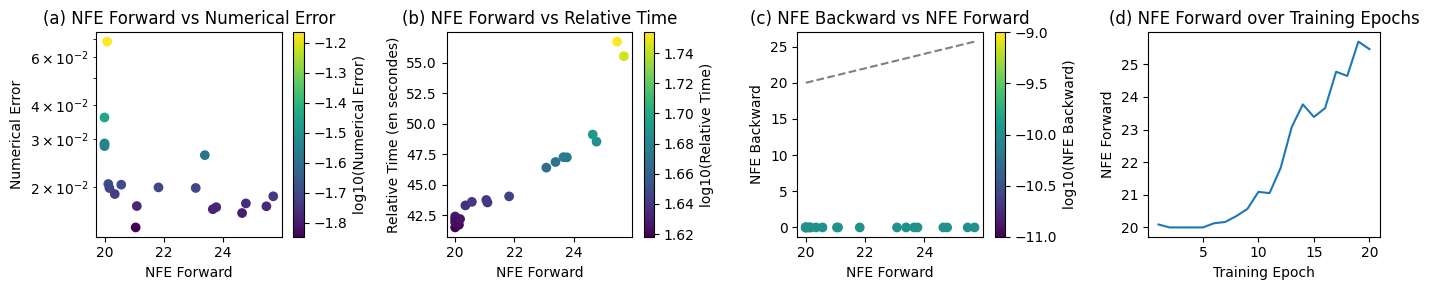

In [ ]:
epochs = np.arange(1, len(nfe_forward_epoch) + 1)

# Plot (a) NFE Forward vs Numerical Error
plt.figure(figsize=(14, 3))
plt.subplot(1, 4, 1)
plt.scatter(nfe_forward_epoch, numerical_error_epoch, c=np.log10(numerical_error_epoch), cmap='viridis')
plt.yscale('log')
plt.colorbar(label='log10(Numerical Error)')
plt.xlabel('NFE Forward')
plt.ylabel('Numerical Error')
plt.title('(a) NFE Forward vs Numerical Error')

# Plot (b) NFE Forward vs Relative Time
plt.subplot(1, 4, 2)
plt.scatter(nfe_forward_epoch, time_epoch, c=np.log10(time_epoch), cmap='viridis')
plt.colorbar(label='log10(Relative Time)')
plt.xlabel('NFE Forward')
plt.ylabel('Relative Time (en secondes)')
plt.title('(b) NFE Forward vs Relative Time')

# Plot (c) NFE Backward vs NFE Forward
plt.subplot(1, 4, 3)
log_nfe_backward_epoch = np.log10(np.array(nfe_backward_epoch) + 1e-10)
plt.scatter(nfe_forward_epoch, nfe_backward_epoch, c=log_nfe_backward_epoch, cmap='viridis')
plt.plot([min(nfe_forward_epoch), max(nfe_forward_epoch)], [min(nfe_forward_epoch), max(nfe_forward_epoch)], 'gray', linestyle='--')  # y=x line for reference
plt.colorbar(label='log10(NFE Backward)')
plt.xlabel('NFE Forward')
plt.ylabel('NFE Backward')
plt.title('(c) NFE Backward vs NFE Forward')

# Plot (d) NFE Forward over Training Epochs
plt.subplot(1, 4, 4)
plt.plot(epochs, nfe_forward_epoch)
plt.xlabel('Training Epoch')
plt.ylabel('NFE Forward')
plt.title('(d) NFE Forward over Training Epochs')

plt.tight_layout()
plt.show()

### Résultats du papier (obtenus avec 160 epochs)

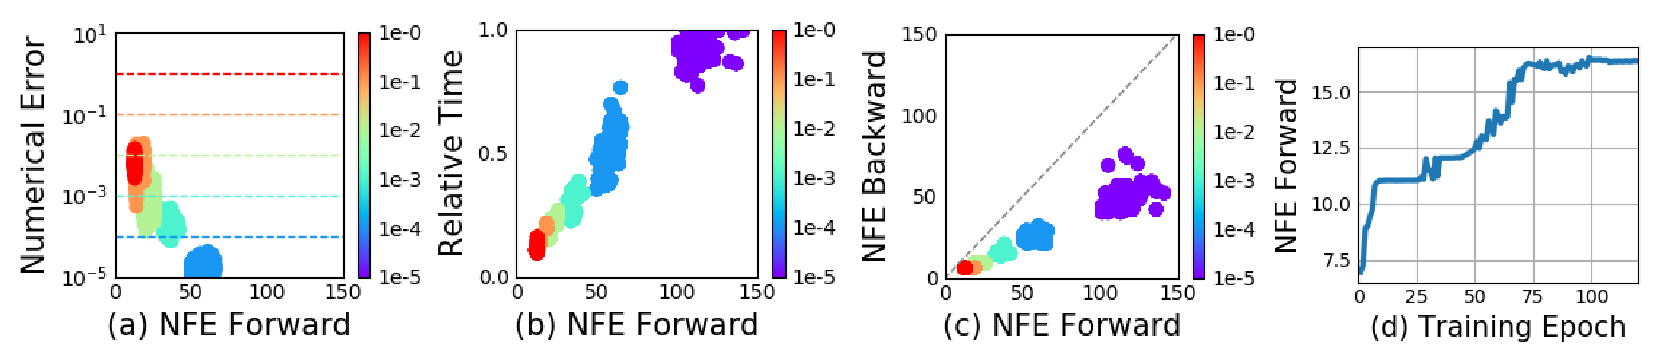

Nos résultats sont cohérents avec ceux du papier, à nombre d'epochs égal.

[1] **Neural Ordinary Differential Equations.**
Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David K. Duvenaud.
NeurIPS 2018.

# Bonus 2 : 4D-Var

La méthode 4D-Var[2] est une méthode à l'état de l'art qui nous aide à fusionner les données réelles avec les modèles prédictifs pour mieux comprendre et prédire des systèmes comme le mouvement d'un pendule. Cette technique ajuste le modèle pour qu'il corresponde aux observations faites pendant un certain temps. Elle est surtout connue en météorologie mais peut être très utile dans d'autres domaines également.

Bien que puissante, la méthode 4D-Var est complexe. Elle nécessite des calculs précis pour ajuster le modèle aux données observées. Notre expérience se concentre sur l'application de 4D-Var au mouvement des pendules, cherchant à comprendre comment différents réglages influencent la précision de la méthode. L'objectif est d'explorer la capacité de 4D-Var à fournir des prédictions précises dans ce contexte.

In [ ]:
# 1 : définition du modèle dynamique (équivalent à celui utilisé pour générer les données)

torch.pi = torch.acos(torch.zeros(1)).item() * 2

def pendulum_dynamics(t, x, alpha=0.2, omega0_square=torch.pi/6):
    """
    Computes the time derivative of the state for a damped pendulum.

    :return: The time derivative of the state.
    """
    q, p = x
    dxdt = [p, -omega0_square * torch.sin(q) - alpha * p]
    return torch.Tensor(dxdt)

def dynamics_model(initial_state, time_horizon=20, dt=0.5):
    """
    Integrates the pendulum dynamics forward in time from an initial state.
    """
    t_eval = torch.arange(0, time_horizon, dt)

    y0 = initial_state
    states = odeint(pendulum_dynamics, y0, t_eval, rtol=1e-10, method='rk4').T

    return states

In [ ]:
# Loss
def observation_loss(initial_state, observations, model=dynamics_model):
    """
    Compute the 4D-Var observation loss for a pendulum system where only the angle is observed.

    :param model: The model representing M_{0 -> t}, the dynamics of the system.
    :param initial_state: The initial state of the system, Y_0.
    :param observations: The actual observations of the angle, theta_t.
    :return: The observation loss.
    """
    # Predict the state at all time steps
    predicted_state = initial_state
    predicted_states = model(predicted_state)[:, 5:21:5]

    # Extract the angle part of the predicted states
    predicted_angles = predicted_states[0, :]

    observations = observations[5:21:5]

    return torch.mean(torch.sqrt((predicted_angles - observations)**2))

In [ ]:
import torch.optim as optim

def fit(V):
    optimizer=optim.LBFGS([torch.zeros(0)],lr=1e-3, max_iter=5000)
    xhat = torch.randn(2) * 2.0 - 1
    r = torch.rand(1)[0] + 1.3
    xhat = xhat / torch.sqrt((xhat**2).sum()) * r
    xhat.requires_grad = True
    optimizer.param_groups[0]['params'][0] = xhat

    def closure():
        optimizer.zero_grad()
        loss=observation_loss(xhat, V)
        loss.backward(retain_graph=True)
        return loss
    loss=optimizer.step(closure)
    print(loss)

    return xhat

for batch in train_loader:
  xhat = fit(batch["states"][0][0])

xhat=xhat.detach()
print(xhat.shape)

KeyboardInterrupt: 

tensor(0.0821, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.6473, dtype=torch.float64, grad_fn=<MeanBackward0>)


<Figure size 2000x1000 with 0 Axes>

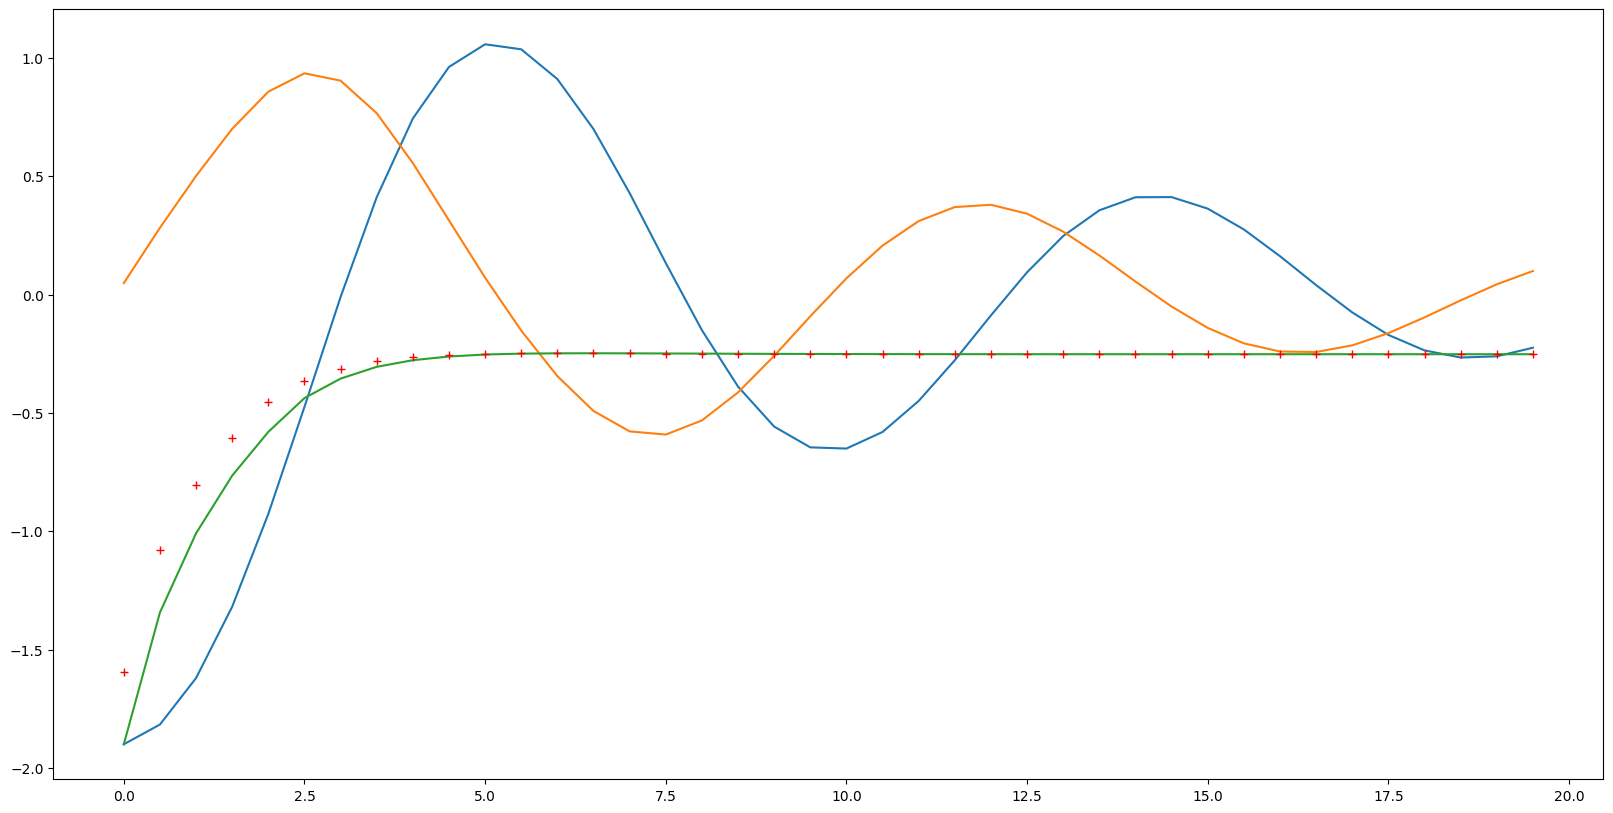

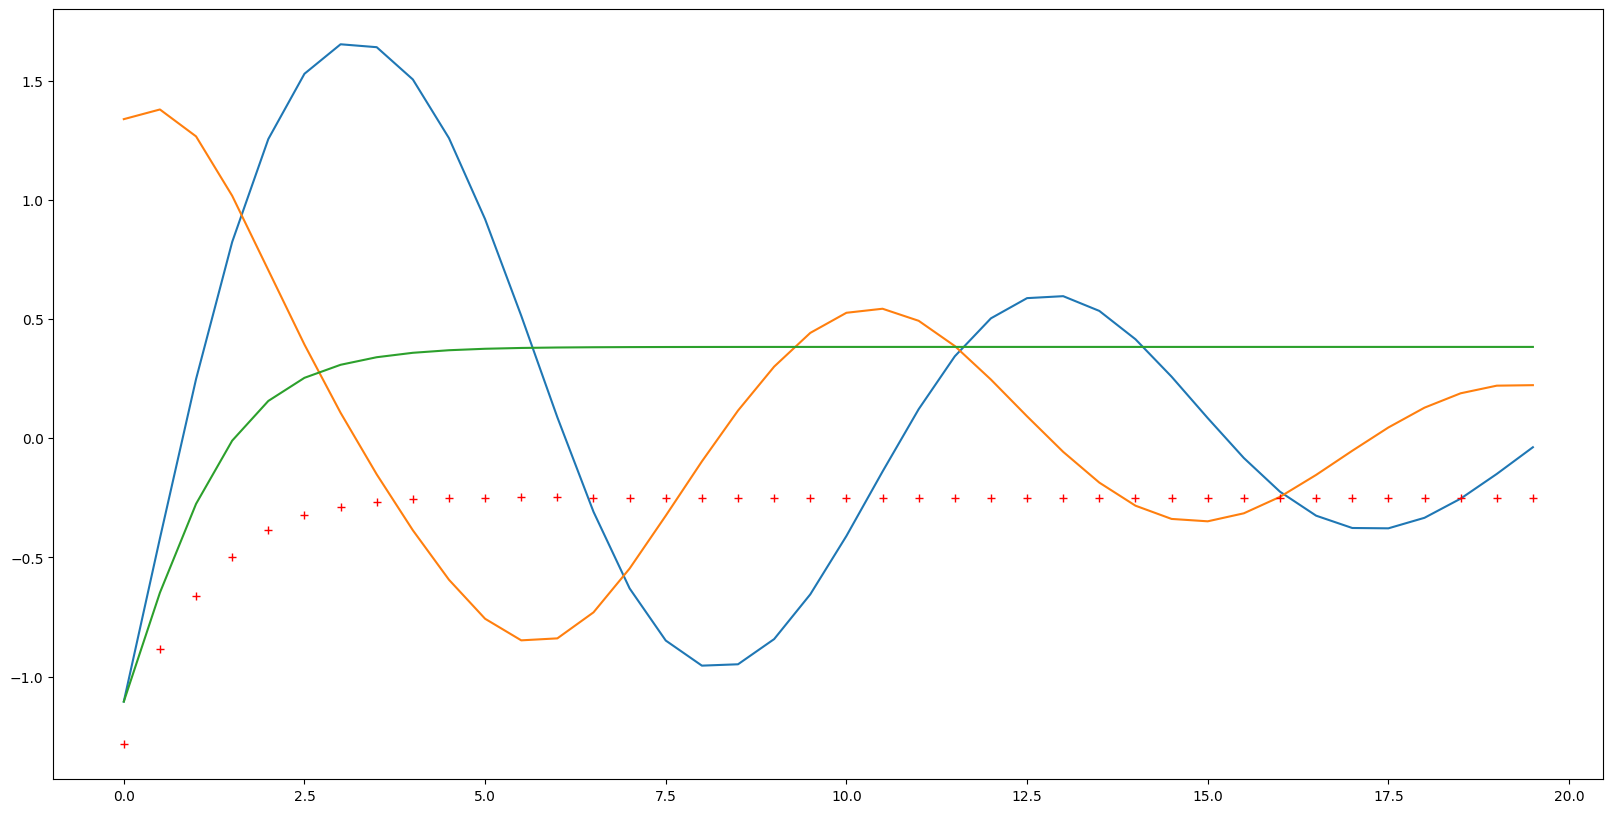

In [ ]:
# The code below plots the predicted values

# Blue line = theta, orange = theta dot, red = predictions with y0 gt, green = predictions with y0 4DVar

plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]

with torch.no_grad():
    for batch in train_loader:
        y0 = batch["states"][:, :, 0].float().to(device)
        t = batch["t"][0].float().to(device)
        p = forecaster_net(y0, t).cpu().detach().numpy()
        y0_hat = fit(batch["states"][0][0]).to(device)
        phat = forecaster_net(y0_hat.unsqueeze(0), t).cpu().detach().numpy()
        fig, axs = plt.subplots(1, 1)

        axs.plot(
            batch["t"][0],
            batch["states"][0, 0, :],
            batch["t"][0],
            batch["states"][0, 1, :],
            batch["t"][0],
            p[0, 0, :],
            batch["t"][0],
            phat[0, 0, :],
            "r+",
        )

    for batch_test in test_loader:
        y0 = batch_test["states"][:, :, 0].float().to(device)
        t = batch_test["t"][0].float().to(device)
        ptest = forecaster_net(y0, t).cpu().detach().numpy()
        y0_hat = fit(batch_test["states"][0][0]).to(device)
        phat_test = forecaster_net(y0_hat.unsqueeze(0), t).cpu().detach().numpy()

        fig, axs = plt.subplots(1, 1)

        axs.plot(
            batch_test["t"][0],
            batch_test["states"][0, 0, :],
            batch_test["t"][0],
            batch_test["states"][0, 1, :],
            batch_test["t"][0],
            ptest[0, 0, :],
            batch_test["t"][0],
            phat_test[0, 0, :],
            "r+",
        )

[2] **Learning 4DVAR inversion directly from observations**. Arthur Filoche, Julien Brajard, Anastase Charantonis, Dominique Béréziat. ICASSP 2023

# Bonus 3 : APHYNITY

## Cette partie consistera à expérimenter le modèle APHYNITY**[3]** vu en cours, et de comparer nos résultats à ceux obtenus précédemment.

In [14]:
!git clone https://github.com/yuan-yin/APHYNITY.git

Cloning into 'APHYNITY'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 33 (delta 7), reused 6 (delta 6), pack-reused 17
Receiving objects: 100% (33/33), 17.23 KiB | 8.62 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [22]:
from APHYNITY.networks import *
from APHYNITY.forecasters import *
from APHYNITY.utils import init_weights
from APHYNITY.datasets import init_dataloaders

In [32]:
model = Forecaster(model_phy=DampedPendulumParamPDE(is_complete=False, real_params=None), model_aug=MLP(state_c=2, hidden=200), is_augmented=True).to(device)

In [33]:
model.load_state_dict(torch.load('./model.pt')['model_state_dict'])
model.eval()

Forecaster(
  (model_phy): DampedPendulumParamPDE(
    (params_org): ParameterDict(
        (alpha_org): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
        (omega0_square_org): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
    )
  )
  (model_aug): MLP(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=200, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=200, out_features=2, bias=True)
    )
  )
  (derivative_estimator): DerivativeEstimator(
    (model_phy): DampedPendulumParamPDE(
      (params_org): ParameterDict(
          (alpha_org): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
          (omega0_square_org): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
      )
    )
    (model_aug): MLP(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=200, bias

<Figure size 2000x1000 with 0 Axes>

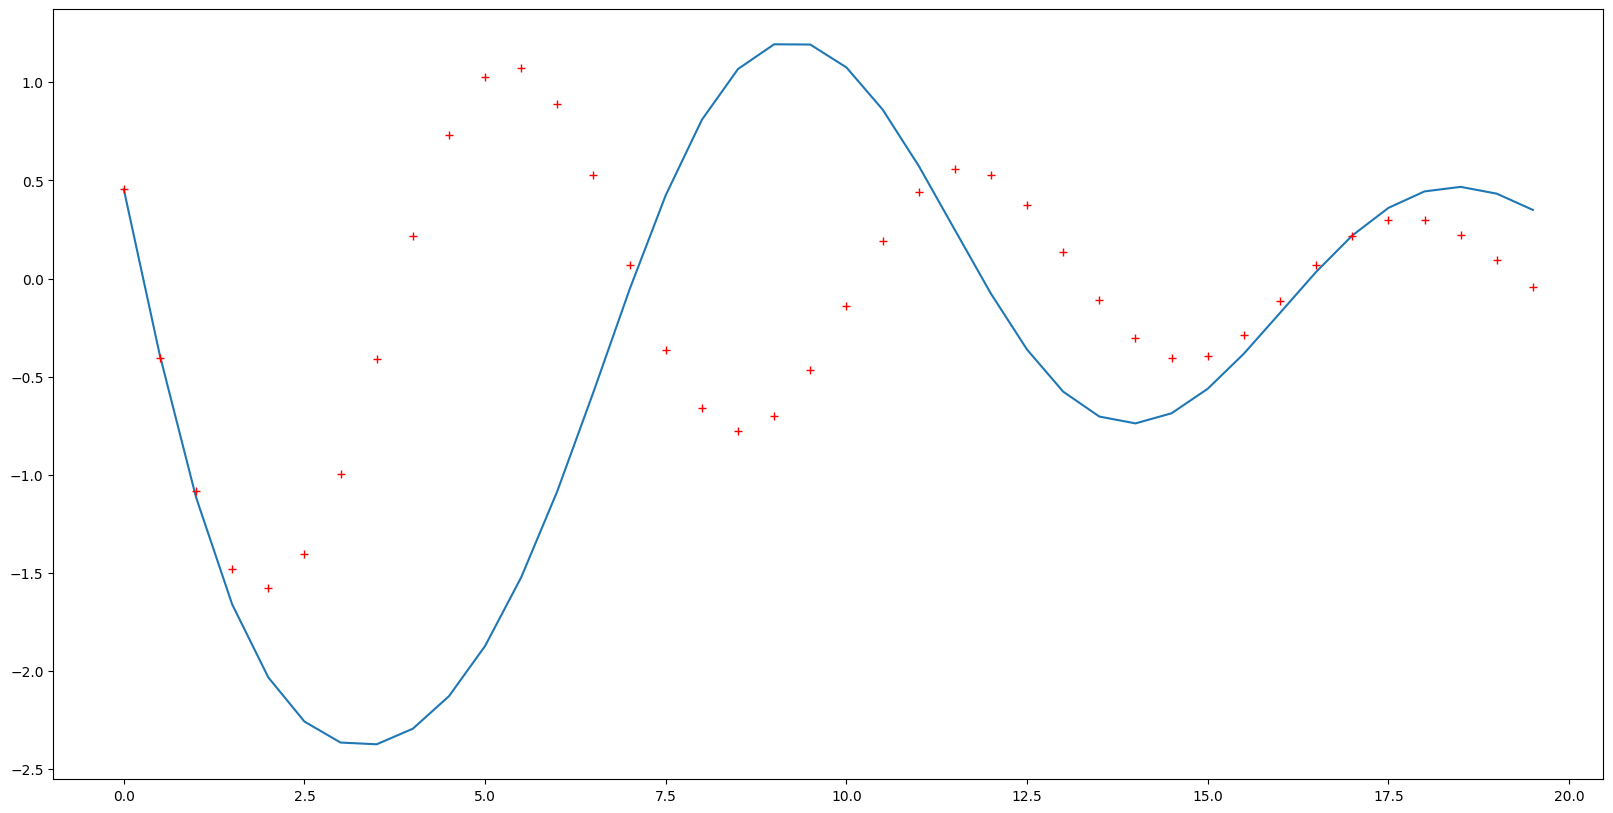

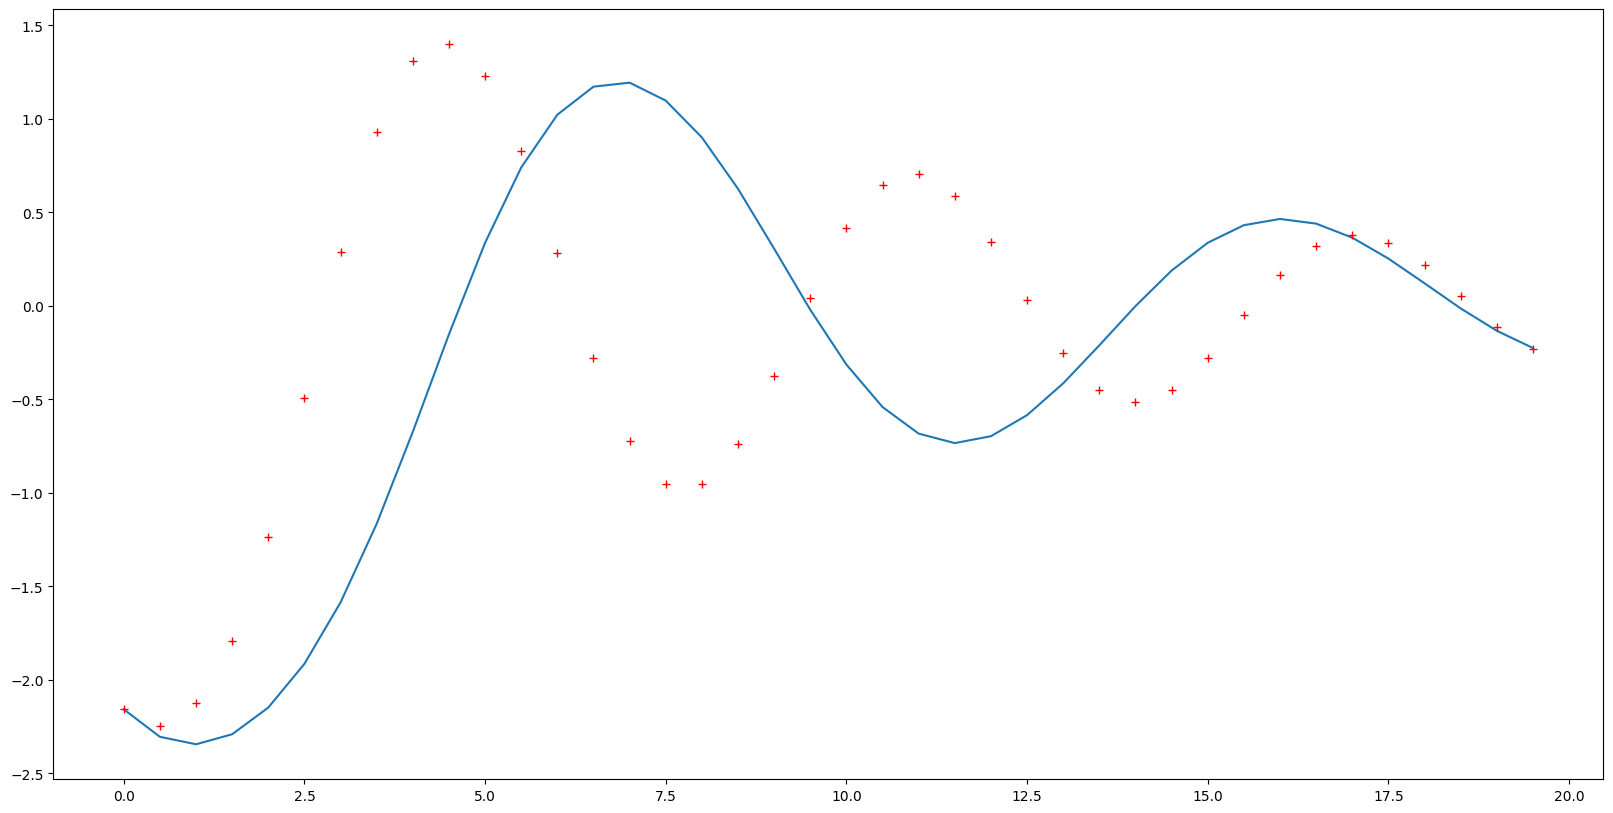

In [36]:
# The code below plots the predicted values

# Blue line = theta, red = predictions

plt.figure()
plt.rcParams["figure.figsize"] = [20, 10]

with torch.no_grad():
    for batch in train_loader:
        y0 = batch["states"][:, :, 0].float().to(device)
        t = batch["t"][0].float().to(device)
        p = model(y0, t).cpu().detach().numpy()
        fig, axs = plt.subplots(1, 1)

        axs.plot(
            batch["t"][0],
            batch["states"][0, 0, :],
            batch["t"][0],
            p[0, 0, :],
            "r+",
        )

    for batch_test in test_loader:
        y0 = batch_test["states"][:, :, 0].float().to(device)
        t = batch_test["t"][0].float().to(device)
        ptest = model(y0, t).cpu().detach().numpy()

        fig, axs = plt.subplots(1, 1)

        axs.plot(
            batch_test["t"][0],
            batch_test["states"][0, 0, :],
            batch_test["t"][0],
            ptest[0, 0, :],
            "r+",
        )

[3] **Augmenting Physical Models with Deep Networks for Complex Dynamics Forecasting**. Yuan Yin, Vincent Le Guen, Jérémie Dona, Emmanuel de Bézenac, Ibrahim Ayed, Nicolas Thome, Patrick Gallinari. ICLR 2021

<!--bibtex

@inproceedings{nODE-NEURIPS2018,
 author = {Chen, Ricky T. Q. and Rubanova, Yulia and Bettencourt, Jesse and Duvenaud, David K},
 booktitle = {Advances in Neural Information Processing Systems},
 editor = {S. Bengio and H. Wallach and H. Larochelle and K. Grauman and N. Cesa-Bianchi and R. Garnett},
 pages = {},
 publisher = {Curran Associates, Inc.},
 title = {Neural Ordinary Differential Equations},
 url = {https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf},
 volume = {31},
 year = {2018}
}

... Other Bibtex entries go here.

-->

<!--bibtex

@inproceedings{nODE-NEURIPS2018,
 author = {Chen, Ricky T. Q. and Rubanova, Yulia and Bettencourt, Jesse and Duvenaud, David K},
 booktitle = {Advances in Neural Information Processing Systems},
 editor = {S. Bengio and H. Wallach and H. Larochelle and K. Grauman and N. Cesa-Bianchi and R. Garnett},
 pages = {},
 publisher = {Curran Associates, Inc.},
 title = {Neural Ordinary Differential Equations},
 url = {https://proceedings.neurips.cc/paper/2018/file/69386f6bb1dfed68692a24c8686939b9-Paper.pdf},
 volume = {31},
 year = {2018}
}

... Other Bibtex entries go here.

-->